## Importing Necessary Libraries

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import speech_recognition as sr
import cv2

## Sign Input by Speech or Text

In [11]:
# Initialize the recognizer
recognizer = sr.Recognizer()

# Use the microphone as the source for audio input
with sr.Microphone() as source:
    print("Please say something...")
    recognizer.adjust_for_ambient_noise(source)  # Adjust for ambient noise
    audio = recognizer.listen(source)

# Convert speech to text
try:
    print("Recognizing...")
    text = recognizer.recognize_google(audio)  # Use Google Speech Recognition
    print(f"You said: {text}")
except sr.UnknownValueError:
    print("Could not understand the audio")
    text = input("Enter sign please: ")
except sr.RequestError as e:
    print(f"Error: {e}")

Please say something...
Recognizing...
You said: hello


## Locating the Coresponding Parquet File

In [12]:
train = pd.read_csv("train.csv")  

# Sign we wish to search for
search_value = text 

# Filter the CSV file to locate the input sign
filtered_data = train[train['sign'] == search_value]

if not filtered_data.empty:
    # Get the second row out of multiples that matches the input sign
    row = filtered_data.iloc[1]

    # Retrieve file path value for the input sign
    value_result = row['path']
    print(f"Matching value found! Corresponding value is: {value_result}")
else:
    print("Sign not found in the CSV file.")

path = value_result

# Split the path by "/"
split_path = path.split('/')

# Extract the values
if len(split_path) >= 3:
    value1 = split_path[1]  # Extracts the participant ID
    value2 = split_path[2].split('.')[0]  # Extracts the sequence ID
else:
    print("Invalid path format")

final_file_path = "train_landmark_files\\" + value1 + "\\" + value2 + ".parquet" # Reconstructing the file path 

Matching value found! Corresponding value is: train_landmark_files/37779/1033181756.parquet


# Display the Sign by Animation

In [13]:

sign = pd.read_parquet(final_file_path)    # Conversion of parquet file to pandas dataframe
sign.y = sign.y * -1                       # Flip y axis

# Hand and Pose Coordinate Values

In [14]:
def get_hand_points(hand):
    x = [[hand.iloc[0].x, hand.iloc[1].x, hand.iloc[2].x, hand.iloc[3].x, hand.iloc[4].x], # Thumb
         [hand.iloc[5].x, hand.iloc[6].x, hand.iloc[7].x, hand.iloc[8].x], # Index
         [hand.iloc[9].x, hand.iloc[10].x, hand.iloc[11].x, hand.iloc[12].x], 
         [hand.iloc[13].x, hand.iloc[14].x, hand.iloc[15].x, hand.iloc[16].x], 
         [hand.iloc[17].x, hand.iloc[18].x, hand.iloc[19].x, hand.iloc[20].x], 
         [hand.iloc[0].x, hand.iloc[5].x, hand.iloc[9].x, hand.iloc[13].x, hand.iloc[17].x, hand.iloc[0].x]]

    y = [[hand.iloc[0].y, hand.iloc[1].y, hand.iloc[2].y, hand.iloc[3].y, hand.iloc[4].y],  #Thumb
         [hand.iloc[5].y, hand.iloc[6].y, hand.iloc[7].y, hand.iloc[8].y], # Index
         [hand.iloc[9].y, hand.iloc[10].y, hand.iloc[11].y, hand.iloc[12].y], 
         [hand.iloc[13].y, hand.iloc[14].y, hand.iloc[15].y, hand.iloc[16].y], 
         [hand.iloc[17].y, hand.iloc[18].y, hand.iloc[19].y, hand.iloc[20].y], 
         [hand.iloc[0].y, hand.iloc[5].y, hand.iloc[9].y, hand.iloc[13].y, hand.iloc[17].y, hand.iloc[0].y]] 
    return x, y

def get_pose_points(pose):
    x = [[pose.iloc[8].x, pose.iloc[6].x, pose.iloc[5].x, pose.iloc[4].x, pose.iloc[0].x, pose.iloc[1].x, pose.iloc[2].x, pose.iloc[3].x, pose.iloc[7].x], 
         [pose.iloc[10].x, pose.iloc[9].x], 
         [pose.iloc[22].x, pose.iloc[16].x, pose.iloc[20].x, pose.iloc[18].x, pose.iloc[16].x, pose.iloc[14].x, pose.iloc[12].x, 
          pose.iloc[11].x, pose.iloc[13].x, pose.iloc[15].x, pose.iloc[17].x, pose.iloc[19].x, pose.iloc[15].x, pose.iloc[21].x], 
         [pose.iloc[12].x, pose.iloc[24].x, pose.iloc[26].x, pose.iloc[28].x, pose.iloc[30].x, pose.iloc[32].x, pose.iloc[28].x], 
         [pose.iloc[11].x, pose.iloc[23].x, pose.iloc[25].x, pose.iloc[27].x, pose.iloc[29].x, pose.iloc[31].x, pose.iloc[27].x], 
         [pose.iloc[24].x, pose.iloc[23].x]
        ]

    y = [[pose.iloc[8].y, pose.iloc[6].y, pose.iloc[5].y, pose.iloc[4].y, pose.iloc[0].y, pose.iloc[1].y, pose.iloc[2].y, pose.iloc[3].y, pose.iloc[7].y], 
         [pose.iloc[10].y, pose.iloc[9].y], 
         [pose.iloc[22].y, pose.iloc[16].y, pose.iloc[20].y, pose.iloc[18].y, pose.iloc[16].y, pose.iloc[14].y, pose.iloc[12].y, 
          pose.iloc[11].y, pose.iloc[13].y, pose.iloc[15].y, pose.iloc[17].y, pose.iloc[19].y, pose.iloc[15].y, pose.iloc[21].y], 
         [pose.iloc[12].y, pose.iloc[24].y, pose.iloc[26].y, pose.iloc[28].y, pose.iloc[30].y, pose.iloc[32].y, pose.iloc[28].y], 
         [pose.iloc[11].y, pose.iloc[23].y, pose.iloc[25].y, pose.iloc[27].y, pose.iloc[29].y, pose.iloc[31].y, pose.iloc[27].y], 
         [pose.iloc[24].y, pose.iloc[23].y]
        ]
    return x, y

### Animation of the entire body utilizing all points available in each frame's data 

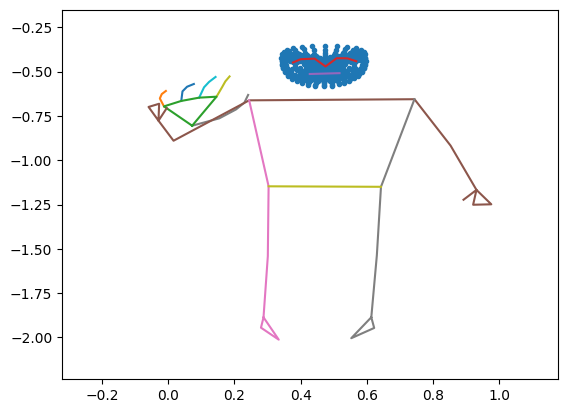

In [15]:
def animation_frame(f):
    # Extract data for frame 'f'
    frame = sign[sign.frame==f]
    left = frame[frame.type=='left_hand']
    right = frame[frame.type=='right_hand']
    pose = frame[frame.type=='pose']
    face = frame[frame.type=='face'][['x', 'y']].values
    
    # Get coordinates for hands and pose points
    lx, ly = get_hand_points(left)
    rx, ry = get_hand_points(right)
    px, py = get_pose_points(pose)

    # Clear the axis for the new frame
    ax.clear()

     # Plot face landmarks as dots
    ax.plot(face[:,0], face[:,1], '.')
    
    # Plot hand and pose landmarks
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    for i in range(len(rx)):
        ax.plot(rx[i], ry[i])
    for i in range(len(px)):
        ax.plot(px[i], py[i])
    
    # Set the limits of the graph to stabilize the video
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
        
## Set the limits on the graph to stabilize the video
xmin = sign.x.min() - 0.2
xmax = sign.x.max() + 0.2
ymin = sign.y.min() - 0.2
ymax = sign.y.max() + 0.2

fig, ax = plt.subplots()        # Create figure and axis
l, = ax.plot([], [])

# Create the animation
animation = FuncAnimation(fig, func=animation_frame, frames=sign.frame.unique())

HTML(animation.to_html5_video())        ## Display video in Jupyter Notebook

### Animation of the left hand only if visible   

c:\Users\Nisa\lib\site-packages\matplotlib\animation.py:1741: UserWarning: Can not start iterating the frames for the initial draw. This can be caused by passing in a 0 length sequence for *frames*.

If you passed *frames* as a generator it may be exhausted due to a previous display or save.
  warnings.warn(


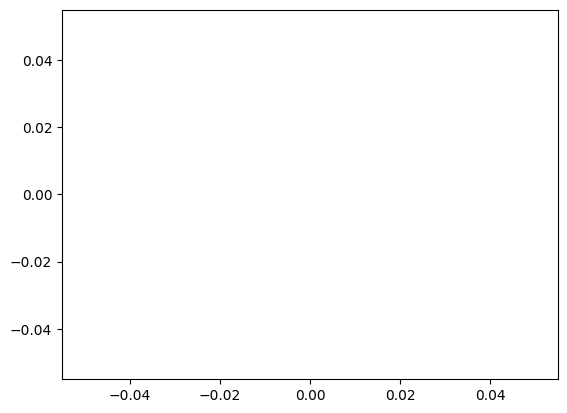

In [16]:
# Filter 'sign' DataFrame to keep rows with 'left_hand' type, dropping any missing values
sign = sign[sign.type=='left_hand'].dropna()

# Extract data for frame 'f'
def animation_frame(f):     
    frame = sign[sign.frame==f]
    left = frame[frame.type=='left_hand']
    
    lx, ly = get_hand_points(left)      # Get coordinates for left hand points
    ax.clear()         
    
    # Plot hand landmarks
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

## Set the limits on the graph to stabilize the video
xmin = sign.x.min() - 0.2
xmax = sign.x.max() + 0.2
ymin = sign.y.min() - 0.2
ymax = sign.y.max() + 0.2

fig, ax = plt.subplots()    # Create figure and axis
l, = ax.plot([], [])

# Create the animation
animation = FuncAnimation(fig, func=animation_frame, frames=sign.frame.unique())

HTML(animation.to_html5_video())        ## Display video in Jupyter Notebook